## 딥러닝 기반 뇌종양 MRI 분류 시스템 개발 및 시각화

In [40]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
from pathlib import Path
import seaborn as sns
from PIL import ImageFile
import pandas as pd
import zipfile

In [4]:
train_dir = pathlib.Path('./dataset/bt_train')
test_dir = pathlib.Path('./dataset/bt_test')

In [6]:
# 클래스 및 이미지 개수 확인
classes = sorted([item.name for item in train_dir.glob('*/') if item.is_dir()])
train_image_count = len(list(train_dir.glob('*/*.jpg')))
test_image_count = len(list(test_dir.glob('*/*.jpg')))

print(f"발견된 클래스: {classes}")
print(f"학습 이미지 개수: {train_image_count}")
print(f"테스트 이미지 개수: {test_image_count}")

발견된 클래스: ['glioma', 'meningioma', 'notumor', 'pituitary']
학습 이미지 개수: 5712
테스트 이미지 개수: 1311


In [7]:
# 각 클래스별 이미지 개수 확인
for class_name in classes:
    train_images = len(list(train_dir.glob(f'{class_name}/*')))
    test_images = len(list(test_dir.glob(f'{class_name}/*')))
    print(f"{class_name}: 학습 {train_images}개, 테스트 {test_images}개 이미지")

glioma: 학습 1321개, 테스트 300개 이미지
meningioma: 학습 1339개, 테스트 306개 이미지
notumor: 학습 1595개, 테스트 405개 이미지
pituitary: 학습 1457개, 테스트 300개 이미지


In [8]:
# 이미지 크기 및 배치 크기 설정
img_height = 150
img_width = 150
batch_size = 32

In [9]:

# 데이터셋 생성
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(train_dir),
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(test_dir),
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [10]:
# 클래스 이름 확인
class_names = train_ds.class_names
print("클래스:", class_names)
num_classes = len(class_names)

클래스: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [11]:
# 데이터셋 성능 최적화
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
# 데이터 증강 레이어 정의
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

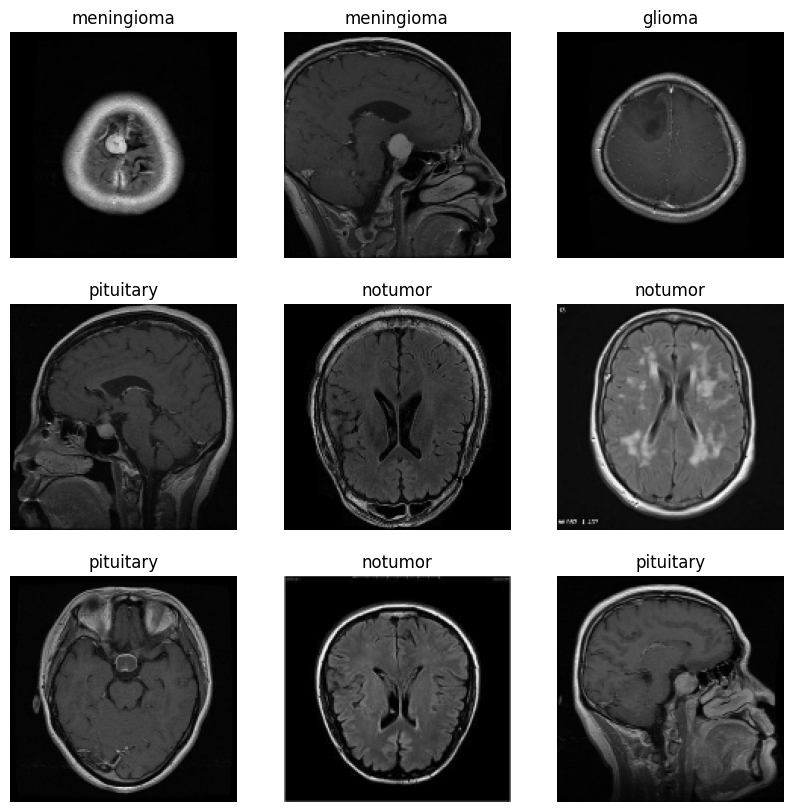

In [13]:
# 샘플 이미지 시각화
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [19]:
from collections import Counter

dataset_path = "./dataset/bt_train"  # 데이터 경로
categories = ["glioma", "meningioma", "notumor", "pituitary"]

for category in categories:
    category_path = os.path.join(dataset_path, category)
    print(f"{category}: {len(os.listdir(category_path))} images")

glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images


In [14]:

# CNN 모델 구성 - 뇌종양 분류에 맞게 더 깊은 모델 구성
model = tf.keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [15]:
# 모델 컴파일
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [18]:
# 모델 구조 출력
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                  

전체 모델 구조


입력층: 150x150x3 크기의 RGB 이미지 입력
총 4개의 Conv2D-MaxPooling 블록
2개의 Dropout 층
2개의 Dense(완전연결) 층
출력층: 4개의 클래스 분류 (glioma, meningioma, no tumor, pituitary)


레이어별 상세 분석:


데이터 전처리 부분:

sequential: 데이터 증강을 위한 레이어
rescaling: 픽셀값을 0-1 사이로 정규화


특징 추출 부분:

첫 번째 블록: 32개 필터 (150x150 → 75x75)
두 번째 블록: 64개 필터 (75x75 → 37x37)
세 번째 블록: 128개 필터 (37x37 → 18x18)
네 번째 블록: 256개 필터 (18x18 → 9x9)


분류 부분:

Flatten: 9x9x256 = 20,736 차원으로 펼침
Dense(256): 20,736 → 256 차원으로 축소
최종 출력: 4개 클래스로 분류




파라미터 수


총 파라미터: 5,698,116개

대부분의 파라미터가 Flatten 후 첫 번째 Dense 층에 집중 (5,308,672개)
이는 모델이 충분한 학습 용량을 가지고 있음을 의미


모든 파라미터가 학습 가능 (Non-trainable params: 0)


모델 특징


점진적으로 증가하는 필터 수 (32→64→128→256)는 깊어질수록 더 복잡한 특징을 학습
Dropout 층들이 과적합 방지에 도움
최종 4개 출력은 각 종양 유형에 대한 확률을 나타냄

이 모델 구조는 이미지 분류에 적합한 전형적인 CNN 아키텍처를 따르고 있다.

In [16]:
# Early Stopping 콜백 설정
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]

In [17]:
# 모델 학습
epochs = 20
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/20
179/179 [==============================] - 240s 1s/step - loss: 0.9453 - accuracy: 0.5980 - val_loss: 0.7987 - val_accuracy: 0.6720
Epoch 2/20
179/179 [==============================] - 262s 1s/step - loss: 0.6807 - accuracy: 0.7365 - val_loss: 1.6368 - val_accuracy: 0.4424
Epoch 3/20
179/179 [==============================] - 209s 1s/step - loss: 0.5809 - accuracy: 0.7708 - val_loss: 0.8106 - val_accuracy: 0.6758
Epoch 4/20
179/179 [==============================] - 200s 1s/step - loss: 0.4869 - accuracy: 0.8134 - val_loss: 0.7917 - val_accuracy: 0.6964
Epoch 5/20
179/179 [==============================] - 200s 1s/step - loss: 0.4488 - accuracy: 0.8255 - val_loss: 1.0848 - val_accuracy: 0.6301
Epoch 6/20
179/179 [==============================] - 190s 1s/step - loss: 0.4099 - accuracy: 0.8428 - val_loss: 0.5985 - val_accuracy: 0.7834
Epoch 7/20
179/179 [==============================] - 197s 1s/step - loss: 0.3636 - accuracy: 0.8603 - val_loss: 0.5419 - val_accuracy: 0.7986

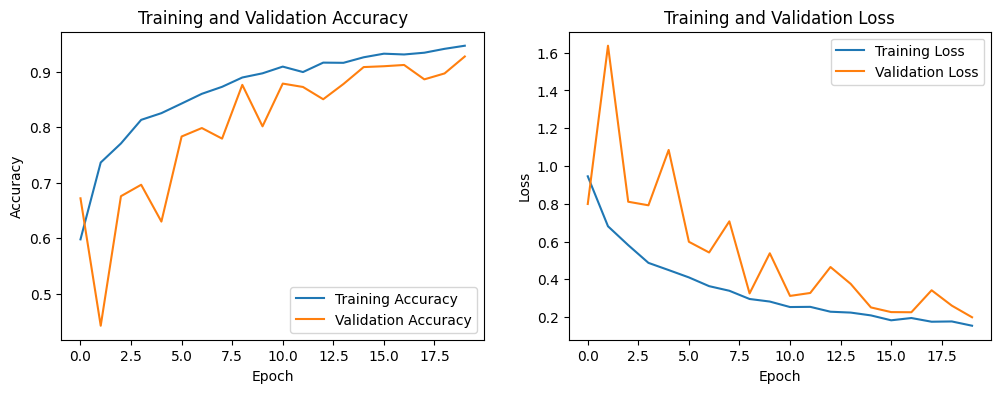

In [20]:
# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [21]:
# 모델 저장
model.save('./model/brain_tumor_classification_model.h5')
print("모델이 'brain_tumor_classification_model.h5'로 저장되었습니다.")

모델이 'brain_tumor_classification_model.h5'로 저장되었습니다.


In [24]:
from tensorflow.keras.models import load_model

In [25]:
model_path = './model/brain_tumor_classification_model.h5'
loaded_model = load_model(model_path)
print("저장된 모델을 성공적으로 불러왔습니다.")

저장된 모델을 성공적으로 불러왔습니다.


In [26]:
# 예측 함수 정의
def predict_brain_tumor(img_path, model, class_names):

    img = tf.keras.preprocessing.image.load_img(
        img_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "이 이미지는 '{}' ({:.2f}% 확률) 입니다."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [37]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

41/41 [==============================] - 10s 237ms/step - loss: 0.1989 - accuracy: 0.9275
Test accuracy: 0.9275


In [38]:
from sklearn.metrics import classification_report
import numpy as np

# 예측값 생성
y_pred = []
y_true = []

for images, labels in test_ds:
    pred = model.predict(images)
    pred_classes = np.argmax(pred, axis=1)
    y_pred.extend(pred_classes)
    y_true.extend(labels)

# 분류 보고서 생성
print(classification_report(y_true, y_pred, 
                          target_names=['glioma', 'meningioma', 'notumor', 'pituitary']))

              precision    recall  f1-score   support

      glioma       0.95      0.91      0.93       300
  meningioma       0.89      0.85      0.87       306
     notumor       0.91      1.00      0.95       405
   pituitary       0.97      0.93      0.95       300

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.93      1311
weighted avg       0.93      0.93      0.93      1311



클래스별 성능 (Classification Report)


Glioma: 정밀도 95%, 재현율 91%, F1-score 93%
Meningioma: 정밀도 89%, 재현율 85%, F1-score 87%
No Tumor: 정밀도 91%, 재현율 100%, F1-score 95%
Pituitary: 정밀도 97%, 재현율 93%, F1-score 95%

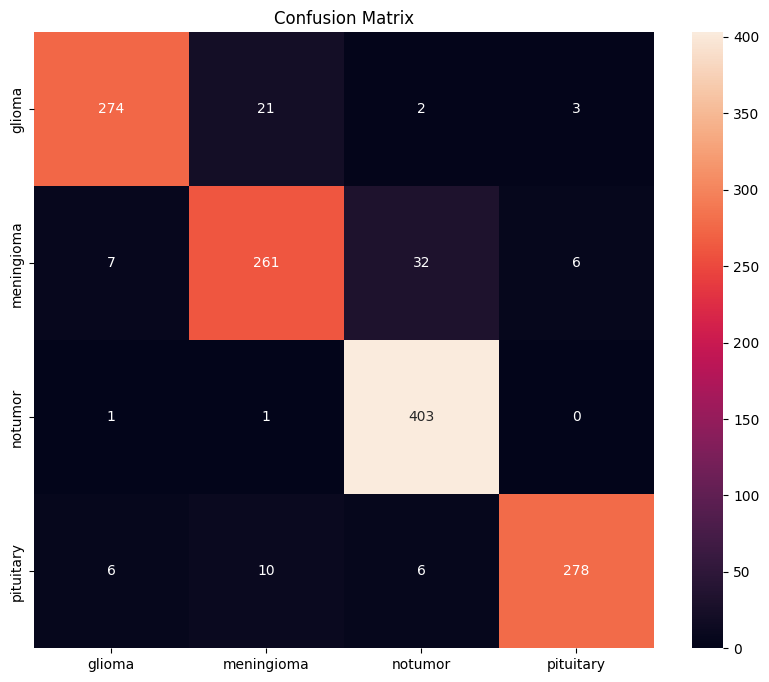

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 혼동 행렬 생성
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=['glioma', 'meningioma', 'notumor', 'pituitary'],
            yticklabels=['glioma', 'meningioma', 'notumor', 'pituitary'])
plt.title('Confusion Matrix')
plt.show()

No Tumor 클래스가 가장 정확하게 분류됨 (403개 정확 분류)
Meningioma 클래스가 상대적으로 다른 클래스와 혼동되는 경우가 많음
주요 오분류 사례:
Meningioma를 No tumor로 오분류: 32건
Glioma를 Meningioma로 오분류: 21건
Pituitary를 Meningioma로 오분류: 10건

In [34]:
test_image_path = './dataset/bt_test/meningioma/Te-me_0016.jpg'

이 이미지는 'meningioma' (47.42% 확률) 입니다.


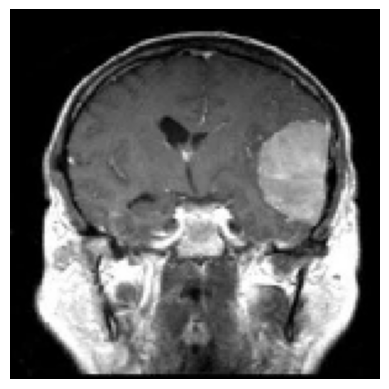

In [35]:
predict_brain_tumor(test_image_path, loaded_model, class_names)